In [1]:
import pandas as pd
import numpy as np
import os

import nltk

import torch

!pip install sentence_transformers
from sentence_transformers import SentenceTransformer

import matplotlib.pyplot as plt
% matplotlib inline

     |████████████████████████████████| 81kB 3.7MB/s 
     |████████████████████████████████| 2.1MB 8.2MB/s 
     |████████████████████████████████| 1.2MB 34.0MB/s 
     |████████████████████████████████| 901kB 43.3MB/s 
     |████████████████████████████████| 3.3MB 33.0MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-1.1.0-cp37-none-any.whl size=119615 sha256=ab60f6f3bfed9418703ef92888b7dfb18d13ec28d02abc55de25b6e6fcb97dc9
  Stored in directory: /root/.cache/pip/wheels/84/cb/21/1066bff3027215c760ca14a198f698bca8fccb92e33e2327eb
Successfully built sentence-transformers


In [2]:
from google.colab import files
uploaded = files.upload()

Saving FA18_messages_with_gender_recipients_hand_lableled.xlsx to FA18_messages_with_gender_recipients_hand_lableled.xlsx


In [3]:
# Read in excel file with recipient gender hand labeled 
df_fall_18_messages = pd.read_excel('FA18_messages_with_gender_recipients_hand_lableled.xlsx', index_col=0)
print(df_fall_18_messages.shape)
df_fall_18_messages.sample(10)

(5039, 5)


,User ID,Sender Race,Sender Gender,Recipient Gender,Text
2518,60252414,WH/ASIAN,F,F,Do you have blue shirt?
1436,27277012,NaN,Unknown,F,I have to forward them to the staff
3211,31792379,WHITE,M,M,It looks more like a thing for professionals o...
1182,25618107,WHITE,F,F,You mean the budget?
4846,43137965,WHITE,F,N,"Sounds good to me, if y’all think we can encom..."
3814,36171062,WHITE,M,F,and what is your email?
3856,24060815,WHITE,F,N,Reminder to everyone: essays are due today at ...
4504,31969201,ASIAN,F,M,I might be late
3039,52541819,ASIAN,M,M,There’s like three essays on there
2678,35990305,WHITE,M,M,Ard then the plan is a go


In [4]:
# Encode recipient gender char as int and create as new column in dataframe
# Remove rows where recipient's gender is unknown
male_val = 0
female_val = 1
neutral_val = 2

def encode(c):
    if (c == 'M'):
        return male_val
    elif (c == 'F'):
        return female_val
    elif (c == 'N'):
        return neutral_val

# Add column in dataframe for encoded gender
df_fall_18_messages['Recipient Gender Encoded'] = [encode(x) for x in df_fall_18_messages['Recipient Gender']]
# Drop nas (some genders were unknown in the dataset)
df_fall_18_messages = df_fall_18_messages[df_fall_18_messages['Recipient Gender Encoded'].notna()]

data = [df_fall_18_messages['Text'], df_fall_18_messages['Recipient Gender Encoded']]

headers = ['Text', 'Recipient Gender Encoded']

df_fall_18_messages = pd.concat(data, axis=1, keys=headers)

print(df_fall_18_messages.shape)
df_fall_18_messages.sample(10)

(4872, 2)


,Text,Recipient Gender Encoded
3717,It’s cool. That’s one less thing to edit so I ...,0.0
764,I’m good for 1,1.0
2410,The slides from what I’ve seen have all the ci...,1.0
1099,Is anyone doing chem office hours,2.0
268,https://drive.google.com/file/d/1gVKdFRYw2jc1_...,2.0
2281,I may be slightly late crowded in d hall,2.0
3520,It’s due tomorrow I think,0.0
3823,@Sebastian McNary When you end up submitting t...,0.0
1678,I live in Potomac if that’s ok!,2.0
4196,True,1.0


In [5]:
# Split multi-sentence messages into individual sentences
nltk.download('punkt')
df_fall_18_sentences = pd.DataFrame(columns=['Sentence', 'Recipient Gender'])
counter = 0
for index, row in df_fall_18_messages.iterrows():
    for sentence in nltk.tokenize.sent_tokenize(row['Text']):
        values_to_add = {'Sentence': sentence, 'Recipient Gender': row['Recipient Gender Encoded']}
        row_to_add = pd.Series(values_to_add, name = counter)
        df_fall_18_sentences = df_fall_18_sentences.append(row_to_add)
        counter += 1

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [6]:
print(np.argwhere(np.isnan(np.array(df_fall_18_sentences['Recipient Gender']))))
print(df_fall_18_sentences.shape)
df_fall_18_sentences.sample(10)

[]
(6354, 2)


,Sentence,Recipient Gender
4564,Do we get a chance to present within our own g...,1.0
6339,"I have my notes, but thank you!",1.0
2289,"Meetings can be 30min or 1 hour, your preference.",2.0
5595,"Umm il see , is it not online ?",0.0
5930,How would we know that they would fund us?,1.0
4835,"I had to take a phone call, I’ll be a few minu...",2.0
856,I sent an email earlier to Dr.K on who to emai...,2.0
2126,I can be available tonight or tomorrow in-pers...,1.0
5695,"I think if they ask, we can say that",1.0
5443,"But I predict that Question 1 will succeed, so...",0.0


In [7]:
print(df_fall_18_sentences['Recipient Gender'].value_counts())

2.0    2918
1.0    1794
0.0    1642
Name: Recipient Gender, dtype: int64


In [8]:
# Get the lists of sentences and their labels.
sentences = df_fall_18_sentences['Sentence'].values
labels = df_fall_18_sentences['Recipient Gender'].values

In [9]:
# Feature extraction
from sklearn.feature_extraction.text import TfidfVectorizer

# Train/Test splitting
from sklearn import model_selection

# Hyper-parameter tuning
from sklearn.model_selection import RandomizedSearchCV,  GridSearchCV, cross_val_score

# Classifiers
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

# Classifier evaluation metrics
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, make_scorer, confusion_matrix, classification_report

# Print confusion matrix
import seaborn as sns

In [10]:
def get_best_estimator(clf, params):
    # Metrics to use for optimization
    # metrics = ['accuracy','f1', 'f1_macro', 'f1_weighted','precision','recall']
    
    # Optimize based on f1_macro score
    grid_search = GridSearchCV(clf, param_grid = params, cv = 3, n_jobs = -1, scoring = 'f1_macro', verbose=2)
    grid_search.fit(X_train, y_train)
    
    # Get estimator with best parameter valuese
    best_estimator = grid_search.best_estimator_
    
    # Print results
    #print("Best parameters set found on training set:\n", grid_search.best_params_)
    #print("Grid scores on training set:\n")
    #print(grid_search.cv_results_)
    print(best_estimator)
    
    # Return best_estimator
    return best_estimator

In [11]:
def svm():
    # Parameters to optimize for svm
    param_grid = {'probability': [True],
                  'C': [1, 50, 100, 500, 1000],
                  'kernel': ['rbf', 'poly'],
                  'gamma': ['auto', 'scale', 0.1, 0.01],
                 }
    # Get optimized parameters from grid search
    svm_clf = SVC(probability=True, kernel='rbf')
    optimized_svm_clf = get_best_estimator(svm_clf, param_grid)
    optimized_svm_clf.fit(X_train, y_train)
    
    # predict recipient gender and print prediction results
    y_pred = optimized_svm_clf.predict(X_test)
    print_results(optimized_svm_clf, y_pred)

In [12]:
def random_forest():
    # Parameters to optimize for rf
    param_grid = {
        'max_depth': [10, 50, 100, 500],
        'min_samples_leaf': [3, 4, 5, 10],
        'min_samples_split': [2, 3, 5, 10],
        'n_estimators': [100, 200, 500]
    }
    
    # Get optimized parameters from grid search
    rf_clf = RandomForestClassifier()
    optimized_rf_clf = get_best_estimator(rf_clf, param_grid)
    optimized_rf_clf.fit(X_train, y_train)
    
    # predict recipient gender and print prediction results
    y_pred = optimized_rf_clf.predict(X_test)
    print_results(optimized_rf_clf, y_pred)

In [13]:
def mlp():
    # Parameters to optimize for rf
    param_grid = {
        'hidden_layer_sizes': [(50,50,50), (50,100,50)],
        'activation': ['tanh', 'relu'],
        'solver': ['sgd', 'adam'],
        'alpha': [0.0001, 0.05],
        'learning_rate': ['constant','adaptive'],
        'max_iter': [200]
    }
    
    # Get optimized parameters from grid search
    mlp_clf = MLPClassifier()
    optimized_mlp_clf = get_best_estimator(mlp_clf, param_grid)
    optimized_mlp_clf.fit(X_train, y_train)
    
    # predict recipient gender and print prediction results
    y_pred = optimized_mlp_clf.predict(X_test)
    print_results(optimized_mlp_clf, y_pred)

In [15]:
def print_results(clf, y_pred):
    # Print accuracy score 
    print("Accuracy Score -> ",accuracy_score(y_pred, y_test)*100)
    
    # Print confusion matrix (heat map)
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='g')
    print(classification_report(y_test, y_pred))
    
    # Print avarage 10-fold cross validation accuracy and f1 scores 
    '''
    svm_cv_accuracy_score = cross_val_score(clf, X_train, y_train, cv=10,scoring='accuracy')
    svm_cv_f1_score = cross_val_score(clf, X_train, y_train, cv=10,scoring='f1_macro')
    print("Mean cv accuracy: ", svm_cv_accuracy_score.mean())
    print("Mean cv f1_macro: ", svm_cv_f1_score.mean())
    '''

In [16]:
def get_and_fit_best_classifiers():
  svm()
  random_forest()
  mlp()

SentenceTransformers (https://www.sbert.net/) is a Python framework for state-of-the-art sentence, text and image embeddings. The framework is based on PyTorch and Transformers and offers a large collection of pre-trained models tuned for various tasks (Paper: https://www.aclweb.org/anthology/D19-1410.pdf). The following pre-trained models were used: 

# stsb-distilbert-base (with grid search)

In [44]:
# Load pre-trained Sentence Transformer Model
model = SentenceTransformer('stsb-distilbert-base')
feature_vectors = model.encode(sentences)

y = df_fall_18_sentences["Recipient Gender"]
X_train, X_test, y_train, y_test = model_selection.train_test_split(feature_vectors, y, test_size=0.25)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(4765, 768)
(4765,)
(1589, 768)
(1589,)


Fitting 3 folds for each of 40 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed: 14.4min
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed: 50.1min finished


SVC(C=50, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)
Accuracy Score ->  48.96161107614852
              precision    recall  f1-score   support

         0.0       0.34      0.32      0.33       413
         1.0       0.38      0.40      0.39       415
         2.0       0.63      0.63      0.63       761

    accuracy                           0.49      1589
   macro avg       0.45      0.45      0.45      1589
weighted avg       0.49      0.49      0.49      1589



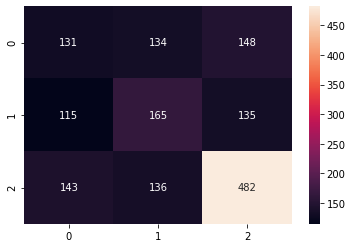

In [45]:
svm()

Fitting 3 folds for each of 192 candidates, totalling 576 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 13.2min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed: 33.2min
[Parallel(n_jobs=-1)]: Done 576 out of 576 | elapsed: 54.2min finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=500, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=4, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
Accuracy Score ->  52.611705475141605
              precision    recall  f1-score   support

         0.0       0.38      0.12      0.19       413
         1.0       0.42      0.30      0.35       415
         2.0       0.57      0.87      0.69       761

    accuracy                           0.53      1589
   macro avg       0.45      0.43      0.41      1589
weighted avg       0.48      0.53      0.47      1589



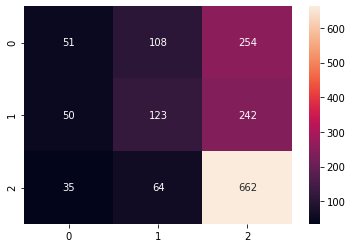

In [46]:
random_forest()

Fitting 3 folds for each of 32 candidates, totalling 96 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done  96 out of  96 | elapsed:  6.9min finished
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MLPClassifier(activation='tanh', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(50, 100, 50), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=200,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='sgd',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Accuracy Score ->  48.89867841409692
              precision    recall  f1-score   support

         0.0       0.36      0.30      0.33       413
         1.0       0.37      0.38      0.38       415
         2.0       0.61      0.65      0.63       761

    accuracy                           0.49      1589
   macro avg       0.45      0.44      0.44      1589
weighted avg       0.48      0.49      0.48      1589



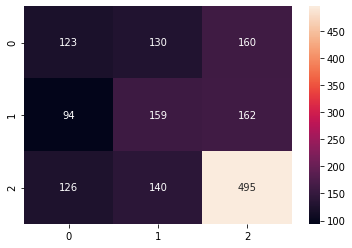

In [47]:
mlp()


# stsb-bert-base (no grid search)


In [17]:
# Load pre-trained Sentence Transformer Model
model = SentenceTransformer('stsb-bert-base')
feature_vectors = model.encode(sentences)

y = df_fall_18_sentences["Recipient Gender"]
X_train, X_test, y_train, y_test = model_selection.train_test_split(feature_vectors, y, test_size=0.25)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)


(4765, 768)
(4765,)
(1589, 768)
(1589,)


In [19]:
svm_clf = SVC(C=10, gamma=0.1, probability=True)
rf_clf = RandomForestClassifier(max_depth=50, min_samples_leaf=3, min_samples_split=3)
mlp_clf = MLPClassifier(alpha=0.05, hidden_layer_sizes=(50, 100, 50))

In [20]:
svm_clf.fit(X_train, y_train)
rf_clf.fit(X_train, y_train)
mlp_clf.fit(X_train, y_train)

MLPClassifier(activation='relu', alpha=0.05, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(50, 100, 50), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=200,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

Accuracy Score ->  48.646947765890495
              precision    recall  f1-score   support

         0.0       0.50      0.05      0.09       429
         1.0       0.51      0.09      0.15       427
         2.0       0.49      0.98      0.65       733

    accuracy                           0.49      1589
   macro avg       0.50      0.37      0.29      1589
weighted avg       0.49      0.49      0.36      1589



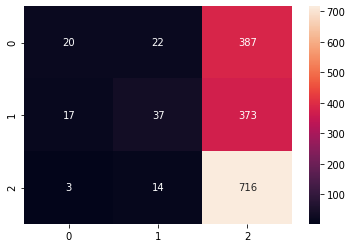

In [21]:
# predict recipient gender and print prediction results
y_pred = svm_clf.predict(X_test)
print_results(svm_clf, y_pred)

Accuracy Score ->  53.55569540591567
              precision    recall  f1-score   support

         0.0       0.42      0.13      0.20       424
         1.0       0.50      0.30      0.38       436
         2.0       0.55      0.91      0.69       729

    accuracy                           0.54      1589
   macro avg       0.49      0.45      0.42      1589
weighted avg       0.51      0.54      0.47      1589



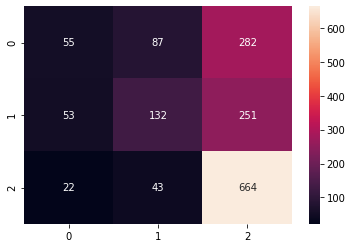

In [30]:
# predict recipient gender and print prediction results
y_pred = rf_clf.predict(X_test)
print_results(rf_clf, y_pred)

Accuracy Score ->  49.905601006922595
              precision    recall  f1-score   support

         0.0       0.38      0.34      0.36       429
         1.0       0.41      0.44      0.42       427
         2.0       0.61      0.63      0.62       733

    accuracy                           0.50      1589
   macro avg       0.47      0.47      0.47      1589
weighted avg       0.50      0.50      0.50      1589



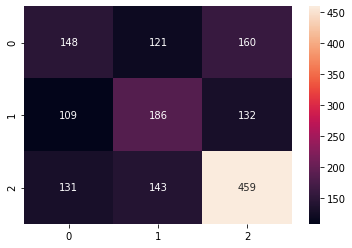

In [23]:
# predict recipient gender and print prediction results
y_pred = mlp_clf.predict(X_test)
print_results(mlp_clf, y_pred)

# stsb-bert-large (no grid search)

In [24]:
# Load pre-trained Sentence Transformer Model
model = SentenceTransformer('stsb-bert-large')
feature_vectors = model.encode(sentences)

y = df_fall_18_sentences["Recipient Gender"]
X_train, X_test, y_train, y_test = model_selection.train_test_split(feature_vectors, y, test_size=0.25)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)


(4765, 1024)
(4765,)
(1589, 1024)
(1589,)


In [25]:
svm_clf = SVC(C=10, gamma=0.1, probability=True)
rf_clf = RandomForestClassifier(max_depth=50, min_samples_leaf=3, min_samples_split=3)
mlp_clf = MLPClassifier(alpha=0.05, hidden_layer_sizes=(50, 100, 50))

In [26]:
svm_clf.fit(X_train, y_train)
rf_clf.fit(X_train, y_train)
mlp_clf.fit(X_train, y_train)

MLPClassifier(activation='relu', alpha=0.05, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(50, 100, 50), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=200,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

Accuracy Score ->  48.39521711768408
              precision    recall  f1-score   support

         0.0       0.50      0.03      0.05       424
         1.0       0.57      0.08      0.14       436
         2.0       0.48      0.99      0.65       729

    accuracy                           0.48      1589
   macro avg       0.52      0.37      0.28      1589
weighted avg       0.51      0.48      0.35      1589



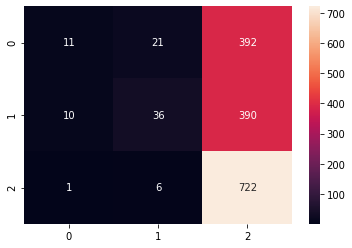

In [27]:
# predict recipient gender and print prediction results
y_pred = svm_clf.predict(X_test)
print_results(svm_clf, y_pred)

Accuracy Score ->  53.55569540591567
              precision    recall  f1-score   support

         0.0       0.42      0.13      0.20       424
         1.0       0.50      0.30      0.38       436
         2.0       0.55      0.91      0.69       729

    accuracy                           0.54      1589
   macro avg       0.49      0.45      0.42      1589
weighted avg       0.51      0.54      0.47      1589



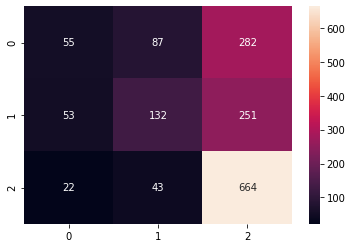

In [28]:
# predict recipient gender and print prediction results
y_pred = rf_clf.predict(X_test)
print_results(rf_clf, y_pred)

Accuracy Score ->  48.26935179358087
              precision    recall  f1-score   support

         0.0       0.35      0.33      0.34       424
         1.0       0.39      0.38      0.39       436
         2.0       0.60      0.63      0.62       729

    accuracy                           0.48      1589
   macro avg       0.45      0.45      0.45      1589
weighted avg       0.48      0.48      0.48      1589



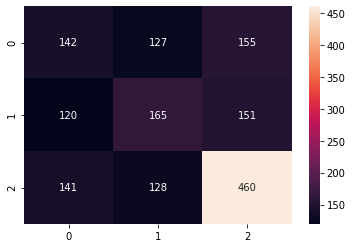

In [29]:
# predict recipient gender and print prediction results
y_pred = mlp_clf.predict(X_test)
print_results(mlp_clf, y_pred)